In [29]:
%matplotlib inline
import pandas as pd;
import numpy as np;
import util.py_data_analysis_util.data_analysis as da;
import matplotlib.pyplot as plt;
import seaborn as sns;
sns.set();
da.ignore_warnings();
da.enable_ipythonnb_code_toggle();

Toggle code

In [4]:
dataset = pd.read_csv("user_operations_190517.csv");

- 按照玩家**当地时间**一天为一个记录单元
- 登录的时候会发送当天之前的本地记录到服务器。所以:
    1. 如果玩家流失，最后一天的数据会缺失。
    2. 如果玩家第一天流失，会没有这个玩家的记录。
- 目前记录了四种类型事件：
    1. UI打开事件
    2. 尝试IAP
    3. IAP成功
    4. 购买金砖礼包成功
    5. (考虑增加出征成功)

- 

In [5]:
NEW_LINE = "\r\n"

In [6]:
import datetime;
def convert_datestring_to_day_num(datestring):
    BASE_Y = 19; #2019
    sec = datestring.split("/")
    y = int(sec[2])
    m = int(sec[0])
    d = int(sec[1])
    date = datetime.datetime(y, m, d);
    day_num = int(date.strftime("%j"));
    day_num += ((y - BASE_Y) * 365);
    return day_num;

In [34]:
## predefined operation types
OP_TYPE_OPEN_UI = 1 
OP_TYPE_IAP_SUCC = 2
OP_TYPE_IAP_ATTEMPT = 3
OP_TYPE_BUY_COIN_ITEM = 4

IGNORE_LIST = {
    "FlashGameTopMenu_t#get_items.pop",
    "FlashGuide_t#btn_blank",
    "FlashGameTopMenu_t#pop_text_small",
    "FlashGameTopMenu_t#get_items_small",
    "FlashGameItemBagPop#this",
    "FlashGameTopMenu_t#you_got_prize",
    "FlashGameTopMenu_t#pay",
    "FlashGuide_t#fade_in",
    "FlashGuide_t#fade_out",
    "FlashPappasPop_t#animation_victory",
    "FlashGuide_t#guide_tap_hint",
};

UI_DESCRIPTION = {
    "FlashShopMain_t#shop_all":"商店主页",
    "FlashMarchPreparation_t#march_reinforce":"出征选兵界面",
    "FlashMarchPreparationPop_t#choose_hero":"出征界面选择英雄弹窗",
    "FlashRecommendedPackage_t#recommended_package":"推荐礼包",
    "FlashGameUIHero#hero_main":"英雄列表",
    "FlashGameMail_t#interface_mails":"邮件首页",
    "FlashChattingMenu_t#chat":"聊天",
    "FlashGameMail_t#menu_2":"邮件2级列表",
    "FlashBuildingUpgrade_t#buildings_upgrade":"建筑升级",
    "FlashBuildingBarrack_t#barracks_train":"造兵/造塔",
    "FlashGameLeagueMain_t#league_main":"联盟主页",
    "FlashGameItemBag#items":"背包",
    "FlashGameUIHero#hero_details":"英雄详情",
    "FlashGameTopMenu_t#not_enough_resources":"资源不足弹窗",
    "FlashWildPop_t#monster_info":"野怪详情",
    "FlashBuildingMenu_t#black_market":"黑市",
    "FlashGameUIEventCenterMenu_t#event_center":"活动中心",
    "FlashFirstRechargeMenu_t#first_recharge":"首冲",
    "FlashFirstRechargeMenu_t#new_server_celebrate":"开服7天乐",
    "FlashBuildingPop_t#speed_up_building":"使用建筑加速道具弹窗",
    "FlashBuildingMenu_t#hospital_cure":"医院治疗",
    "FlashGameUILeagueTreasure#alliance_treasures":"联盟宝藏",
    "FlashGameUIHeroPop#upgrade_equipment":"英雄装备升级",
    "FlashGameLadder_t#arena_work":"竞技场",
    "FlashQuestMenu_t#quest_all":"任务",
    "FlashGameUnitEvolvementPop_t#pop_uprage":"士兵强化/解锁弹窗",
    "FlashFortress_t#entrance":"要塞主页",
    "FlashGameGetResource_t#this":"资源购买列表",
    "FlashGameTopMenu_t#refill_energy":"购买体力弹窗",
    "FlashWildPop_t#wreckage":"废墟",
    "FlashScienceResearch_t#sciences":"个人科技主页",
    "FlashScienceResearch_t#millitary_sciences":"个人科技:军事",
    "FlashScienceResearch_t#development_sciences":"个人科技:发展",
    "FlashScienceResearch_t#logistics_sciences":"个人科技:后勤",
    "FlashScienceResearchPop_t#sciences_research":"个人科技详情弹窗",
    "FlashGameInterfacePop_t#city_buff":"BUFF界面",
    "FlashGameMailDetail_t#system_mails2":"系统邮件详情",
    "FlashGameMailDetail_t#monster_hunting":"PVE战报",
    "FlashGameUILeagueGift#league_gift":"联盟礼物",
    "FlashGameUILeagueTechnology#alliance_sciences":"联盟科技",
    "FlashGameMailDetail_t#pvp_report":"PVP战报",
    "FlashBuildingMenu_t#exchange_res":"资源补给站",
    "FlashGameUIHeroPop#evolve":"英雄进化",
    "FlashGameUIHeroPop#star_up":"英雄升星",
    "FlashBuildingMenu_t#quiz":"小测验",
    "FlashGuide_t#guide_dialog":"引导对话",
    "FlashLeagueBattle_t#alliance_battle":"联盟战争",
    "FlashGameInterfacePop_t#attack_warnings":"攻击预警",
    "FlashGameUIHeroPop#add_exp":"经验药水",
    "FlashGameMailDetail_t#personal_information":"私聊",
    "FlashGameUILeagueShop#league_store":"联盟商店",
    "FlashLottery#lucky_card":"抽卡",
    "FlashBuildingMenu_t#army_overview":"兵力一览",
    "FlashLordPop_t#setting_langueage":"游戏语言设置",
    "FlashLordInfo_t#settings_main":"设置",
    "FlashGameMailDetail_t#scouting_report":"侦察报告",
    "FlashGameSoulSkill#soul_skills":"魂技",
    "FlashGameTopMenu_t#exchange_gems":"金砖换宝石",
    "FlashBattleReplay_t#this":"战斗录像",
    "FlashGameLeagueManagement_t#league_management":"联盟管理",
    "FlashLeagueMember_t#league_members":"联盟成员",
    "FlashGameInterfacePop_t#off_line_report":"离线报告",
    "FlashGameUnitEvolvement_t#unit_evolvement":"士兵强化首页",
    "FlashShopPop_t#subscription_gold_bricks":"订阅：金砖",
    "FlashShopPop_t#subscription_daily_pack":"订阅：每日礼包",
    "FlashWelfare_t#welfare_all":"福利(签到/投资)",
    "FlashBuildingMenu_t#city_overview":"城市信息总览",
    "FlashLordInfo_t#alliance_monarch":"玩家个人信息",
    "FlashGameTopMenu_t#speed_up_marching":"使用加速道具/buff详情",
    "FlashGameTopMenu_t#pop_find":"材料获取途径弹窗",
    "FlashQuestMenu_t#story_line":"剧情界面",
    "FlashLeaguePop_t#donate":"联盟科技捐献弹窗",
    "FlashLordInfo_t#interface_kings_information":"非同盟玩家信息",
    "FlashLordInfo_t#interface_kings_information2":"同盟玩家信息",
    "FlashGameUIRank#might_information":"排行榜主页面",
    "FlashGameUIRankDetail#alliance_might_rank":"排行榜详情",
    "FlashGameUIHeroPop#hero_stats":"英雄状态弹窗",
    "FlashGameUIEvilCave#gve_evil_cave":"联盟探险首页",
    "FlashGameUIEvilCave#gve":"联盟探险准备/战斗中",
    "FlashGameUIEvilCave#gve_choose_level":"联盟探险选关",
    "FlashGameUIEvilCavePop#gve_clearing":"联盟探险结果",
    "FlashLordPop_t#interface_change_avatar2":"更改头像/头像框",
    "FlashLeaguePop_t#interface_alliance":"联盟信息弹窗",
    "FlashGameInterfacePop_t#discovery_details":"基地车详情",
    "FlashGameInterfacePop_t#discovery_equipment_details":"基地车零件升级",
    "FlashGameLadderPop_t#rank_board":"竞技场排名",
    "FlashLeaguePop_t#pop_reward":"查看每日任务奖励/领奖",
    "FlashGameTopMenu_t#pack_content":"查看礼包内物品信息",
    "FlashPappas_t#demon_portal":"避难所首页",
    "FlashPappasPop_t#enemy_details":"避难所关卡详情",
    "FlashBuildingMenu_t#appoint":"英雄任命",
    "FlashGameUIHeroPop#skill_details":"技能详情",
    "FlashWildPop_t#pop_container":"能源箱信息",
    "FlashLottery#lottery":"大乐透",
    "FlashWildPop_t#find_resources":"查找地图资源",
}

CHEST_ITEMS = [18501,18502,18503,18504,18505,18506,18507,18508,18509,18510,18511,18512,18520,
               18521,18522,18523,18524,18525,18526,18527,18528,18529,18530,18531,18532,18533,
               18534,18535,18536,18537,18538,18539,18540,18541,18542,18543,18544,18545,18546,
               18547,18548,18549,18550,18551,18552,18553,18554,18555,18556,18557,18558,18701,
               18702,18703,18704,18705,18706,18707,18708,18709,18710,18711,18712,18713,18714,
               18715,18716,18717,18718,18719,18720,18721,18722,18723,18724,18725,18726,18727,
               18728,18729,18730,18731,18732,18733,18734,18735,18736,18737,18738,18739,18740,
               18741,18742,18743,18744,18745,18746,18747,18748,18749,18750,18751,18752,18753,
               18754,18755,18756,18757,18758,18759,18760,18761,18762,18763,18764,18765,18766,
               18767,18768,18769,18770,18771,18772,18773,18774,18775,18776,18777,18778,18779,
               18780,18781,18782,18783,18784,18785,18786,18787,18788,18789,18790,18791,18792,
               18793,18794,18795,18796,18797,18798,18799,18800,18801,18802,18803,18804,18805,
               18806,18807,18808,18809,18810,18811,18812,18813,18814,18815,18816,18817,18818,
               18819,18820,18821,18822,18823,18824,18825,18826,18827,18828,18829,18830,18831,
               18832,18833,18834,18835,18836,18837,18838,18839,18840,18841,18842,18843,18844,
               18845,18846,18847,18848,18849,18850,18851,18852,18853,18854,18855,18856,18857,
               18858,18859,18860,18861,18862,18863,18864,18865,18866,18867,18868,18869,18870,
               18871,18872,18873,18874,18875,18876,18877,18878,18879,18880,18881,18882,18883,
               18884,18885,18886,18887,18888,18889,18890,18891,18892,18893];

def is_ignored_ui(ui_name):
    return ui_name in IGNORE_LIST;

def get_ui_desc_by_name(ui_name):
    if ui_name in UI_DESCRIPTION:
        return UI_DESCRIPTION[ui_name];
    else:
        return ui_name;
    
def is_chest_item(item_id):
    chest_id = int(item_id);
    return chest_id in CHEST_ITEMS;b



In [8]:
def generate_ui_table(ui_table_array):
    match_table = {}
    for i in ui_table_array:
        args = i.split(":")
        match_table[args[0].strip()] = int(args[1])
        
    return match_table;

def get_ui_name_by_id(ui_table, id):
    for k, v in ui_table.items():
        if v == id:
            return k

def parse_record(record):
    SEQUENCE_PREFIX = "op_seq: ";
    UI_TABLE_PREFIX = ("ui:" + NEW_LINE);
    TOTAL_SPENT_PREFIX = "spent: ";
    DATE_PREFIX = "date: ";
    USERID_PREFIX = "user_id: ";
    LANG_PREFIX = "device_lang: ";
    
    op_seq_start = record.find(SEQUENCE_PREFIX);
    
    if op_seq_start == -1:
        return
    
    lang_start = record.find(LANG_PREFIX);
    dev_lang = "unknown";
    if lang_start != -1:
        lang_start += len(LANG_PREFIX);
        dev_lang = record[lang_start:op_seq_start].strip(NEW_LINE);
        
    op_seq_start += len(SEQUENCE_PREFIX)
    ui_table_start = record.find(UI_TABLE_PREFIX)
    
    if ui_table_start == -1:
        return
    
    spent_start = record.find(TOTAL_SPENT_PREFIX)
    date_start = record.find(DATE_PREFIX)
    userid_start = record.find(USERID_PREFIX)
    
    if spent_start == -1:
        return
    
    if date_start == -1:
        return
    
    if userid_start == -1:
        return
    
    op_seq_array = record[op_seq_start:ui_table_start].strip(NEW_LINE)[:-1].split("#")
    ui_table_start += len(UI_TABLE_PREFIX)
    ui_table_array = record[ui_table_start:spent_start].splitlines()
    total_spent = float(record[spent_start:date_start].strip(NEW_LINE).split(":")[1])
    date = record[date_start:userid_start].strip(NEW_LINE).split(":")[1]
    user_id = record[userid_start:-1].strip(NEW_LINE).split(":")[1].strip()
    
    ui_table = generate_ui_table(ui_table_array)
    
    new_op_array = []
    
    ui_num = 0;
    has_iap_attempt = False;
    has_gold_brick_consumption = False;
    for i in op_seq_array:
        op_args = i.split(":")
        op_type = int(op_args[0])
        if op_type == OP_TYPE_OPEN_UI:
            ui_id = int(op_args[1])
            ui_name = get_ui_name_by_id(ui_table, ui_id)
            if not is_ignored_ui(ui_name):
                new_op_array.append(str(OP_TYPE_OPEN_UI) + ":" + ui_name);
                ui_num += 1;
        elif op_type == OP_TYPE_IAP_ATTEMPT:
            new_op_array.append(i);
            has_iap_attempt = True;
        elif op_type == OP_TYPE_BUY_COIN_ITEM:
            new_op_array.append(i);
            has_gold_brick_consumption = True;
        else:
            new_op_array.append(i);
    
    
    return pd.DataFrame(data = {
        "user_id":[user_id],
        "date":[date],
        "day_index":[convert_datestring_to_day_num(date)],
        "spent":[total_spent], 
        "ops":[new_op_array],
        "ui_num":[ui_num],
        "dev_lang":[dev_lang],
        "has_iap_attempt":[has_iap_attempt],
        "has_gold_brick_consumption":[has_gold_brick_consumption],
    });
  

In [9]:
parsed_data = pd.DataFrame(data = {
    "user_id":[],
    "date":[], 
    "spent":[], 
    "ops":[]
});

def parse_origin_data(content):
    global parsed_data;
    parsed_data = parsed_data.append(parse_record(content), ignore_index = True);

dataset["content"].apply(lambda x: parse_origin_data(x));

--- 

### UI打开次数分布(人/天)

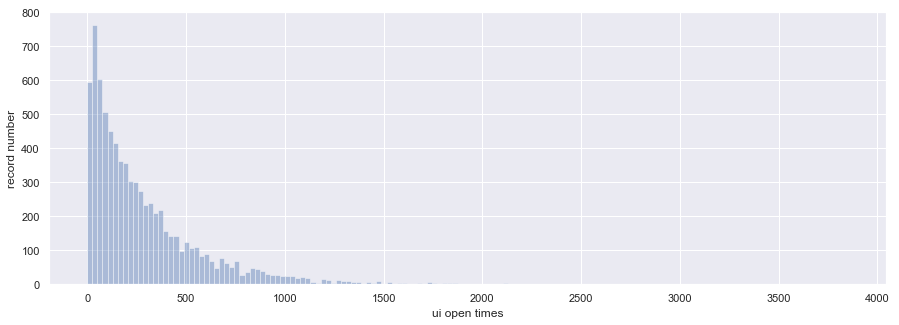

In [10]:
plt.figure(figsize = (15, 5));
ax = sns.distplot(parsed_data["ui_num"], kde = False, bins = 150);
ax.set(ylabel = "record number", xlabel = "ui open times");

In [11]:
parsed_data["ui_num"].describe()["max"]

3852.0

访问次数最多的界面

In [12]:
ui_access_times = {}

def count_ui_access_times(ops):
    global ui_access_times;
    for i in ops:
        args = i.split(":");
        op_type = int(args[0]);
        if op_type == OP_TYPE_OPEN_UI:
            if args[1] not in ui_access_times:
                ui_access_times[args[1]] = 0;
            ui_access_times[args[1]] += 1;
            
parsed_data["ops"].apply(lambda x: count_ui_access_times(x));

df_ui_access_times = pd.DataFrame.from_dict(ui_access_times, orient='index', columns = ["times"]).sort_values(by = "times", ascending = False);

In [13]:
TOP_N = 20;
for index, row in df_ui_access_times.iloc[:TOP_N].iterrows():
    print("{:<30}\t{:>10}".format(get_ui_desc_by_name(row.name), row.times))

出征选兵界面                        	    239897
野怪详情                          	     95501
建筑升级                          	     86208
邮件首页                          	     80694
聊天                            	     73343
造兵/造塔                         	     72848
联盟主页                          	     68899
推荐礼包                          	     63127
士兵强化/解锁弹窗                     	     57481
邮件2级列表                        	     56667
查找地图资源                        	     51700
避难所关卡详情                       	     51234
英雄列表                          	     49573
剧情界面                          	     49141
背包                            	     43288
使用建筑加速道具弹窗                    	     42108
引导对话                          	     41483
竞技场                           	     36962
英雄装备升级                        	     36959
活动中心                          	     36901


### TODO: 选兵界面的类型
- 野怪
- 竞技场
- 避难所
- 联盟探险
- other(采集/pvp)

In [14]:
# let's take care of "FlashMarchPreparation_t#march_reinforce"
pre_ui_marching_preparation = {}
def traverse_marching_preparation(ops):
    pre_ui = None;
    for i in ops:
        args = i.split(":");
        op_type = int(args[0])
        if op_type == OP_TYPE_OPEN_UI:
            if args[1] == "FlashMarchPreparation_t#march_reinforce":
                if pre_ui is not None:
                    if pre_ui not in pre_ui_marching_preparation:
                        pre_ui_marching_preparation[pre_ui] = 0;
                    pre_ui_marching_preparation[pre_ui] += 1;
            else:
                pre_ui = args[1];

parsed_data["ops"].apply(lambda x: traverse_marching_preparation(x));

monster_attack_times = pre_ui_marching_preparation["FlashWildPop_t#monster_info"];
wreckage_mining_times = pre_ui_marching_preparation["FlashWildPop_t#wreckage"];
gve_times = pre_ui_marching_preparation["FlashGameUIEvilCave#gve"] + pre_ui_marching_preparation["FlashGameUIEvilCave#gve_evil_cave"];
vault_times = pre_ui_marching_preparation["FlashPappasPop_t#enemy_details"];
arena_times = pre_ui_marching_preparation["FlashGameLadder_t#arena_work"] + pre_ui_marching_preparation["FlashGameLadderPop_t#daily_chanllenges"];


In [15]:
print(monster_attack_times / 148434 * 100);
print(wreckage_mining_times / 148434 * 100);
print(gve_times / 148434 * 100);
print(vault_times / 148434 * 100);
print(arena_times / 148434 * 100);

57.11292561003544
5.723082312677688
7.166147917593005
30.563752240052818
9.32603042429632


In [16]:
promotion_ui_times = df_ui_access_times.loc["FlashRecommendedPackage_t#recommended_package"].times;
print("推荐礼包界面总出现次数为: {}".format(promotion_ui_times));

推荐礼包界面总出现次数为: 63127


In [17]:
ui_access_times = {};
parsed_data.loc[parsed_data["ui_num"] > 3800, "ops"].apply(lambda x: count_ui_access_times(x));

In [18]:
prev_ui_list = {}
def buy_item_from_promotion(ops):
    pre_ui = None;
    global prev_ui_list;
    for i in ops:
        args = i.split(":");
        op_type = int(args[0])
        if op_type == OP_TYPE_BUY_COIN_ITEM:
            item_id = int(args[1])
            if is_chest_item(item_id) and pre_ui is not None:  
                if pre_ui not in prev_ui_list:
                    prev_ui_list[pre_ui] = 0
                prev_ui_list[pre_ui] += 1;
        elif op_type == OP_TYPE_OPEN_UI:
            pre_ui = args[1];
    
    return False;

parsed_data["ops"].apply(lambda x: buy_item_from_promotion(x));

pd_buy_chest = pd.DataFrame.from_dict(prev_ui_list, orient = "index", columns = ["times"]).sort_values(by = "times", ascending = False);

In [19]:
buy_chest_from_promotion = pd_buy_chest["times"].loc["FlashRecommendedPackage_t#recommended_package"];
buy_chest_total = pd_buy_chest["times"].sum();

print("从推荐窗口卖出的宝箱占总卖出宝箱的 {:.3f}%".format(buy_chest_from_promotion * 100 / buy_chest_total));
print("从推荐窗口卖出的宝箱占总弹出次数的 {:.3f}%".format(buy_chest_from_promotion * 100 / promotion_ui_times));


从推荐窗口卖出的宝箱占总卖出宝箱的 22.206%
从推荐窗口卖出的宝箱占总弹出次数的 0.242%


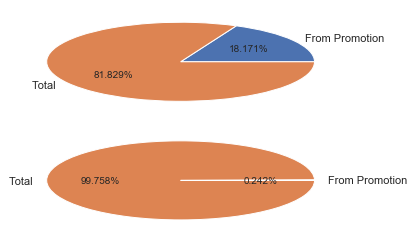

In [20]:
plt.subplot(2, 1, 1)
plt.pie([buy_chest_from_promotion, buy_chest_total], labels = ["From Promotion", "Total"], autopct = "%.3f%%");
plt.subplot(2, 1, 2)
plt.pie([buy_chest_from_promotion, promotion_ui_times], labels = ["From Promotion", "Total"], autopct = "%.3f%%");

In [21]:
pd_buy_chest

,times
FlashShopMain_t#shop_all,447
FlashRecommendedPackage_t#recommended_package,153
FlashGameTopMenu_t#pack_content,54
FlashShopPop_t#subscription_gold_bricks,15
FlashShopPop_t#subscription_daily_pack,12
FlashBuildingMenu_t#black_market,5
FlashGameTopMenu_t#exchange_gems,3


### 出现在玩家每天常用窗口(top10)中次数最多的

In [22]:
total_most_accessed_ui = {}
def calc_most_opened_ui(ops):
    global total_most_accessed_ui;
    opened_ui = {}
    for i in ops:
        args = i.split(":")
        op_type = int(args[0])
        if op_type == OP_TYPE_OPEN_UI:
            ui_name = args[1];
            if ui_name not in opened_ui:
                opened_ui[ui_name] = 0;
                
            opened_ui[ui_name] += 1;
            
    pd_most_accessed = pd.DataFrame.from_dict(opened_ui, orient = "index", columns = ["times"]).sort_values(by = "times", ascending = False);  
    
    top_n = min(10, len(pd_most_accessed));
    for i, v in pd_most_accessed.iloc[:top_n].iterrows():
        if i not in total_most_accessed_ui:
            total_most_accessed_ui[i] = 0;
        total_most_accessed_ui[i] += 1;
parsed_data["ops"].apply(lambda x: calc_most_opened_ui(x));

pd_total_most_accessed = pd.DataFrame.from_dict(total_most_accessed_ui, orient = "index", columns = ["times"]).sort_values(by = "times", ascending = False);  



In [23]:
TOP_N = 20;
for index, row in pd_total_most_accessed.iloc[:TOP_N].iterrows():
    pct = float(row.times * 100 / len(parsed_data));
    print("{:<30}\t{:>10}\t{:.2f}%".format(get_ui_desc_by_name(row.name), row.times, pct))

出征选兵界面                        	      6413	81.59%
邮件首页                          	      4247	54.03%
造兵/造塔                         	      3784	48.14%
推荐礼包                          	      3605	45.87%
联盟主页                          	      3578	45.52%
野怪详情                          	      3514	44.71%
建筑升级                          	      3340	42.49%
邮件2级列表                        	      2818	35.85%
士兵强化/解锁弹窗                     	      2015	25.64%
英雄列表                          	      1956	24.89%
聊天                            	      1924	24.48%
查找地图资源                        	      1913	24.34%
避难所关卡详情                       	      1800	22.90%
背包                            	      1602	20.38%
竞技场                           	      1570	19.97%
查看每日任务奖励/领奖                   	      1510	19.21%
活动中心                          	      1415	18.00%
使用建筑加速道具弹窗                    	      1410	17.94%
英雄装备升级                        	      1277	16.25%
剧情界面                          	      1237	15.74%


### 每天上线后打开的第一个界面:


### 流失曲线？

### 流失用户

In [24]:

def is_churn_user(x):
    #today = datetime.datetime.now();
    #day_num = convert_datestring_to_day_num(today.strftime("%d/%m/%y"));

    latest_info_date = "05/15/20";
    latest_day_num = convert_datestring_to_day_num(latest_info_date);
    last_login_day = x["max"];
    total_login_day_num = x["len"];
        
    if last_login_day <= latest_day_num - 2:
        return True;
    else:
        return False;


In [25]:
#group users by user_id
pd_user_id_group = parsed_data.groupby(["user_id"])["day_index"].agg([len, max]);
churn_user_group = pd_user_id_group.loc[pd_user_id_group.apply(lambda x: (is_churn_user(x)), axis = 1)].sort_values(by = "len", ascending = False);
print(churn_user_group.shape)

print(churn_user_group.loc[churn_user_group["len"] > 2].shape)
churn_user_id_list = churn_user_group.index;

(1792, 2)
(945, 2)


[ 81. 244. 713. 481. 374. 510. 178. 967. 750.] 5cae469ec15e00677f674145
[166.  56. 124.  31.  16.] 5c646e2c66863bef339f334d
[898.] 5cdd7f5d0b1b7b6859a466d6
[62.] 5c76f23d0c1b7bf60989752d
[30.] 5ccc8a9ec15e00c847e045d4
[240. 192.  12. 176.  24.  77. 298.  19.] 5c7187db0c1b7bbd19e64abb
[570.] 5cdd7ee40b1b7b6859a4623e
[201.] 5cdd60770b1b7b6859a39255
[136. 251. 390. 374. 268. 111.  96. 293.] 5ca5589d66863ba868ccb123
[46.] 5cd60c6dc15e0005602c5488
[ 81. 395. 137. 414. 226. 326. 274. 325. 476.] 5c8effcb0c1b7beb71c8bae7
[ 52. 347. 117. 295. 158. 214. 250. 178. 214.] 5c89330466863b9e358d1f17
[240. 192.  12. 176.  24.  77. 298.  19.] 5c7187db0c1b7bbd19e64abb
[442. 508. 971. 380. 390. 322. 362. 259.] 5caf6e27c15e00a6411bf697
[ 45. 254. 294.  98. 198. 135. 113. 223. 169.] 5c757b530c1b7bf6097e500e
[ 68. 168.] 5cdb464ac15e0005603f689a
[2.] 5cdda8e10b1b7b6859a6b52a
[79.] 5cdb6bfec15e000560400872
[250.] 5cddcbd30b1b7b6859a8c3d5
[164.] 5c4a822f66863b4e7779910e
[26.] 5cc45472c15e00d673cd0431
[ 58. 168.

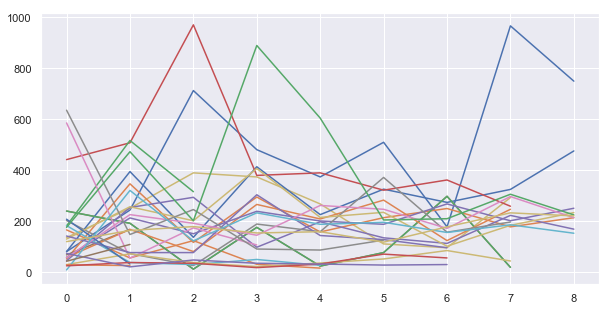

In [26]:
sample_num = 50
sample_list = np.random.randint(0, len(churn_user_id_list), sample_num)
plt.figure(figsize=(10, 5))
for i in sample_list:
    user_id = churn_user_id_list[i]
    ordered_rec = parsed_data.loc[parsed_data["user_id"]
                                  == user_id].sort_values(by="day_index")

    data_array = np.array(ordered_rec["ui_num"])
    print(data_array, user_id)
    sns.lineplot(data=data_array)

#### 流失用户最后操作的都是什么呢？

In [27]:
parsed_data.loc[parsed_data["user_id"] == "5cd71a7cc15e000560307e95"]

,date,day_index,dev_lang,has_gold_brick_consumption,has_iap_attempt,ops,spent,ui_num,user_id
2595,05/11/19,131.0,unknown,False,False,"[1:FlashOpening_t#opening_animaiton, 1:FlashSt...",0.0,1190.0,5cd71a7cc15e000560307e95
3243,05/12/19,132.0,unknown,False,False,"[1:FlashBuildingBarrack_t#barracks_train, 1:Fl...",0.0,2588.0,5cd71a7cc15e000560307e95
4405,05/13/19,133.0,unknown,False,False,"[1:FlashBuildingMenu_t#quiz, 1:FlashBuildingPo...",0.0,239.0,5cd71a7cc15e000560307e95
5291,05/14/19,134.0,unknown,False,False,[1:FlashFirstRechargeMenu_t#new_server_celebra...,0.0,353.0,5cd71a7cc15e000560307e95
6228,05/15/19,135.0,unknown,False,False,"[1:FlashGameCityLevelup_t#congratulations, 1:F...",0.0,178.0,5cd71a7cc15e000560307e95
7117,05/16/19,136.0,en,False,False,"[1:FlashGameInterfacePop_t#off_line_report, 1:...",0.0,500.0,5cd71a7cc15e000560307e95


In [28]:
b = churn_user_group.reset_index();
b.loc[b["user_id"] == "5cd71a7cc15e000560307e95"]

,user_id,len,max
688,5cd71a7cc15e000560307e95,6.0,136.0
